<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/2023/nbs/examples/Transfer_Learning_neuralforecast_2023_7_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Nixtla/datasetsforecast.git@main

  Cloning https://github.com/Nixtla/datasetsforecast.git (to revision main) to /tmp/pip-req-build-c6u41u42
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/datasetsforecast.git /tmp/pip-req-build-c6u41u42
  Resolved https://github.com/Nixtla/datasetsforecast.git to commit b66884e7c011402699d977113f1e3ff06904a0d9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.8/283.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.9 MB/s eta 0:00:00
  Crea

In [2]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [3]:
import numpy as np
import pandas as pd
import torch
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

from datasetsforecast.m4 import M4
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersDF
from neuralforecast.losses.numpy import mae, mse

In [4]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [5]:
torch.cuda.is_available()

True

In [6]:
Y_df, _, _ = M4.load(directory='./', group='Monthly', cache=True)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

91.7MiB [00:01, 90.9MiB/s]
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
7.94MiB [00:00, 42.1MiB/s]
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
4.34MiB [00:00, 78.0MiB/s]                 
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
100%|██████████| 3.56M/3.56M [00:00<00:00, 16.5MiB/s]


,unique_id,ds,y
0,M1,1970-01-01 00:00:00.000000001,8000.0
1,M1,1970-01-01 00:00:00.000000002,8350.0
2,M1,1970-01-01 00:00:00.000000003,8570.0
3,M1,1970-01-01 00:00:00.000000004,7700.0
4,M1,1970-01-01 00:00:00.000000005,7080.0
...,...,...,...
11246406,M9999,1970-01-01 00:00:00.000000083,4200.0
11246407,M9999,1970-01-01 00:00:00.000000084,4300.0
11246408,M9999,1970-01-01 00:00:00.000000085,3800.0
11246409,M9999,1970-01-01 00:00:00.000000086,4400.0


In [7]:
horizon = 12
stacks = 3
models = [NHITS(input_size=5 * horizon,
                h=horizon,
                max_steps=100,
                stack_types = stacks*['identity'],
                n_blocks = stacks*[1],
                mlp_units = [[256,256] for _ in range(stacks)],
                n_pool_kernel_size = stacks*[1],
                batch_size = 32,
                scaler_type='standard',
                n_freq_downsample=[12,4,1])]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
nf.save(path='./results/transfer/', model_index=None, overwrite=True, save_dataset=False)

# 4. Transfer M4 to AirPassengers
We load the stored model with the core.NeuralForecast.load method, and forecast AirPassenger with the core.NeuralForecast.predict function.

In [9]:
fcst2 = NeuralForecast.load(path='./results/transfer/')

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [10]:
# We define the train df.
Y_df = AirPassengersDF.copy()
mean = Y_df[Y_df.ds<='1959-12-31']['y'].mean()
std = Y_df[Y_df.ds<='1959-12-31']['y'].std()

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

In [11]:
Y_hat_df = fcst2.predict(df=Y_train_df).reset_index()
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,NHITS
0,1.0,1960-01-31,425.642517
1,1.0,1960-02-29,430.904755
2,1.0,1960-03-31,442.543396
3,1.0,1960-04-30,439.769257
4,1.0,1960-05-31,455.598877


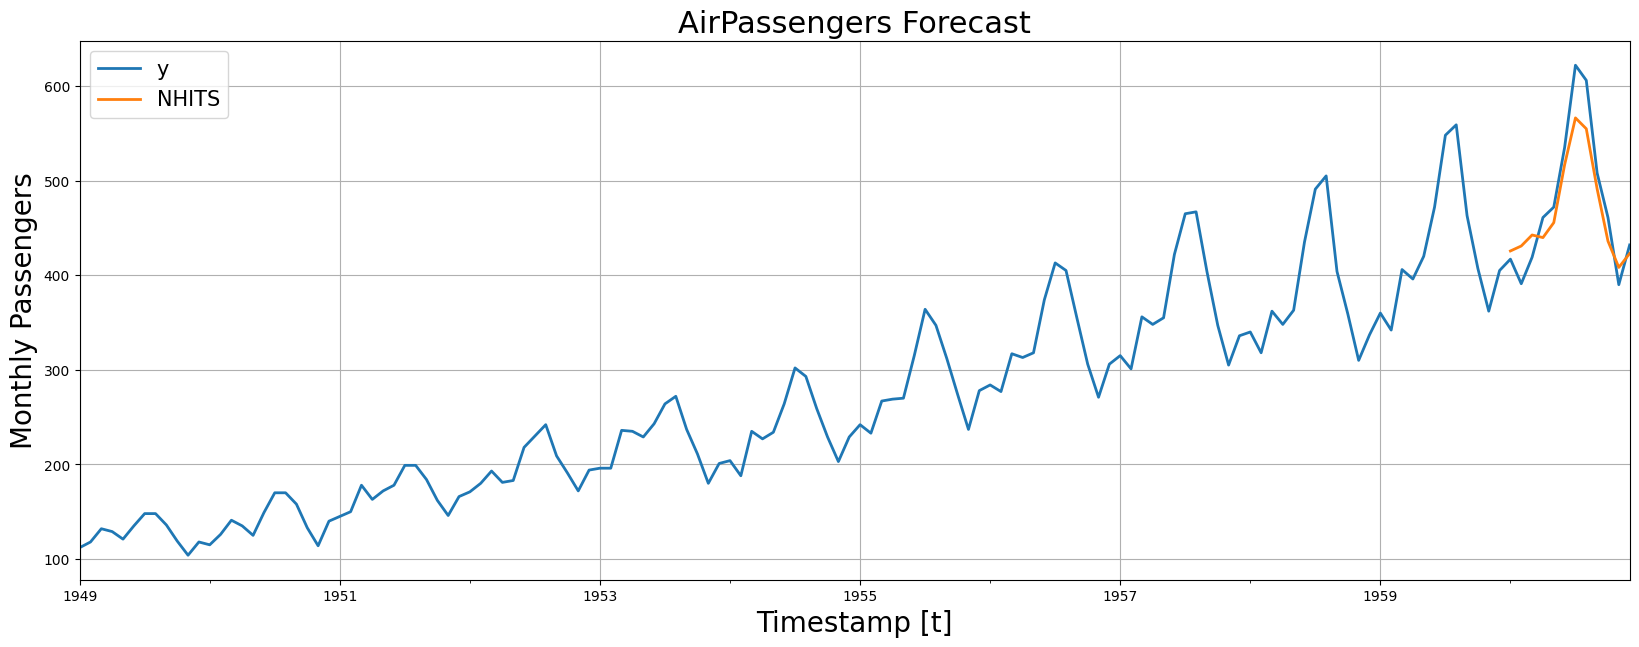

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [13]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['NHITS'].values

In [14]:
print('NHITS     MAE: %0.3f' % mae(y_hat, y_true))

NHITS     MAE: 25.317
